<a href="https://colab.research.google.com/github/janielcarneiro/Segmentacao_de-imagens_de_cancer_de_mama/blob/main/Segmenta%C3%A7%C3%A3o_de_imagens_de_c%C3%A2ncer_de_mama_Deep_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
import numpy as np
import keras
import pandas as pd
import imageio.v2 as imageio
import cv2
import matplotlib.pyplot as plt
#Parada antecipada # Reduzir LR no platô
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2DTranspose, BatchNormalization, ReLU, Conv2D, UpSampling2D, MaxPool2D, Dropout
from keras import Input, Model
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Pré-processamento e das Imagens para Jogar Para Treinamento

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def preprocess_images_and_masks(folder_path):

  # Classifique a lista de nomes de arquivos (ordenar pasta garantir consistencia)
  filenames = sorted(os.listdir(folder_path))

  # Carregue as imagens e máscaras da pasta
  # Tirando várias máscaras para uma imagem porque sou um covarde
  images = [cv2.imread(os.path.join(folder_path, f)) for f in filenames if f.endswith('.png') and not (f.endswith('_mask.png') or f.endswith('_mask_1.png') or f.endswith('_mask_2.png'))]
  masks = [cv2.imread(os.path.join(folder_path, f), cv2.IMREAD_GRAYSCALE) for f in filenames if f.endswith('_mask.png')]

  # Redimensione as imagens e máscaras para o tamanho desejado
  desired_size = (256, 256)
  images = [cv2.resize(image, desired_size) for image in images]
  masks = [cv2.resize(mask, desired_size, interpolation=cv2.INTER_NEAREST) for mask in masks]

  # Converta as imagens para o formato RGB (se ainda não estiverem)
  images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]

  # Normalize os valores de pixel das imagens e máscaras (Colocar os valores pixels entre 0 e 1)
  images = [image / 255.0 for image in images]
  masks = [mask / 255.0 for mask in masks]

  # Converta as imagens e máscaras em matrizes numpy
  images = np.array(images)
  masks = np.array(masks)

  return images, masks

In [ ]:
# Defina os caminhos para as três pastas
benign_folder = '/content/drive/MyDrive/benign'
malignant_folder = '/content/drive/MyDrive/malignant'
normal_folder = '/content/drive/MyDrive/normal'

# Pré-processe as imagens e máscaras das pastas
benign_images, benign_masks = preprocess_images_and_masks(benign_folder)
malignant_images, malignant_masks = preprocess_images_and_masks(malignant_folder)
normal_images, normal_masks = preprocess_images_and_masks(normal_folder)

# Concatene as imagens e máscaras das três pastas (Criar um Único Array)
# que contem todas as imagens empilhadas verticalmente
images = np.concatenate((benign_images, malignant_images, normal_images), axis=0)
masks = np.concatenate((benign_masks, malignant_masks, normal_masks), axis=0)

In [ ]:
# Verifique as dimensões dos arrays de imagens e máscaras
if len(images) == 0 or len(masks) == 0:
  print("Erro: a matriz de imagens ou máscaras está vazia")
elif len(images) != len(masks):
  print("Erro: Incompatibilidade no número de imagens e máscaras")
else:
  # Embaralhe as imagens e máscaras juntas
  combined = list(zip(images, masks)) #faz conversão de tuplas chaves valor
  np.random.shuffle(combined) #alterar a ordem
  images, masks = zip(*combined) #descompactar

  # Converta as imagens e máscaras em matrizes numpy
  images = np.array(images)
  masks = np.array(masks)

  # calcular o número de imagens em cada divisão
  num_images = len(images)
  num_train = int(0.90 * num_images)
  num_val = int(0.075 * num_images)
  num_test = num_images - num_train - num_val

  # Divida as imagens e máscaras em conjuntos de treinamento, validação e teste
  train_images = images[:num_train]
  train_masks = masks[:num_train]
  val_images = images[num_train:num_train+num_val]
  val_masks = masks[num_train:num_train+num_val]
  test_images = images[num_train+num_val:]
  test_masks = masks[num_train+num_val:]

Visualize pares de imagens e máscaras

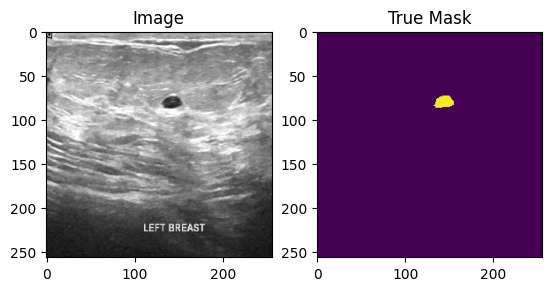

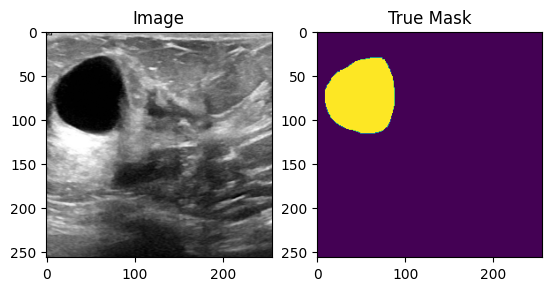

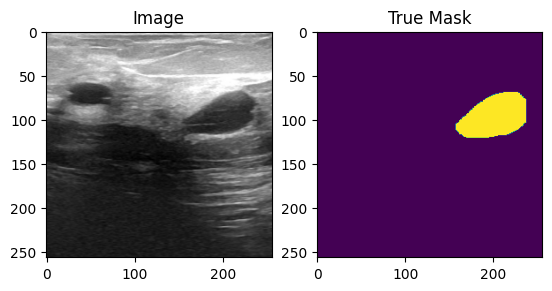

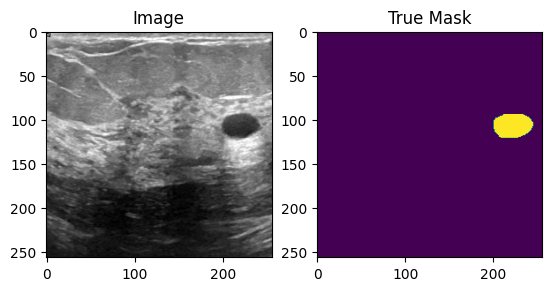

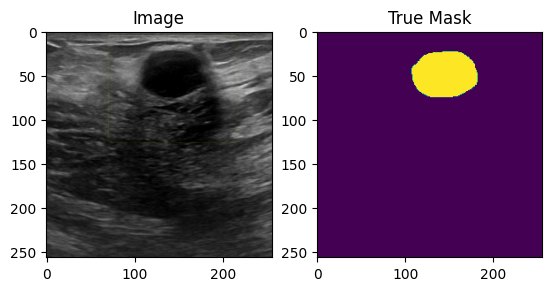

In [ ]:
for i in range(5):
    image = benign_images[i]
    mask = benign_masks[i]

    # Exibir a imagem e a máscara verdadeira
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image)
    ax1.set_title("Image")
    ax2.imshow(mask)
    ax2.set_title("True Mask")

    plt.show()

Definição e ajuste do modelo (Aonde fica a Magica)

In [ ]:
#Essa camada é usada para aumentar as dimensões espaciais da entrada, restaurando a resolução original da imagem ou representação da
#característica,o que pode ser útil em tarefas como a reconstrução de imagens a partir de representações mais abstratas ou na geração
#de imagens detalhadas
#Conv2D cria uma camada de convolução, aplicando uma transformação linear à entrada por meio de convolução com um conjunto de filtros.
#BatchNormalization normaliza a saída da camada de convolução, ajudando na estabilização e aceleração do treinamento da rede neural.
#ReLU é uma função de ativação que aplica não-linearidade à saída da camada de convolução.
#UpSampling2D executa uma operação de upsampling, aumentando a resolução espacial da saída da camada convolucional
def create_upsample_layer(filters, kernel_size, padding='same', kernel_initializer='he_normal'):
    """ This function creates a layer that upsamples an input tensor using a convolutional, batch
    normalization, and ReLU activation, followed by an upsampling operation. """
    def layer(x):
        x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = UpSampling2D(size=(2, 2))(x)
        return x
    return layer

#"Downsampling" é o processo de redução da resolução ou dimensões de um sinal ou imagem.
#Conv2D cria uma camada de convolução, aplicando uma transformação linear à entrada por meio de convolução com um conjunto de filtros.
#BatchNormalization normaliza a saída da camada de convolução, ajudando na estabilização e aceleração do treinamento da rede neural.
#ReLU é uma função de ativação que aplica não-linearidade à saída da camada de convolução.
#MaxPool2D executa uma operação de max pooling, reduzindo a resolução espacial da saída da camada convolucional.
def create_downsample_layer(filters, kernel_size, padding='same', kernel_initializer='he_normal'):
    """ This function creates a layer that downsamples an input tensor using a convolutional, batch
    normalization, and ReLU activation, followed by a max pooling operation. """
    def layer(x):
        x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = MaxPool2D(pool_size=(2, 2))(x)
        return x
    return layer

dropout_rate = 0.15

# Example usage
inputs = Input(shape=(256, 256, 3))
# Encoder part of the DeepUNet
x = create_downsample_layer(64, 3, padding='same', kernel_initializer='he_normal')(inputs)
x = create_downsample_layer(128, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(256, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(512, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(1024, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(2048, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)

# Decoder part of the DeepUNet #Reastaurar a resolução Real
x = create_upsample_layer(1024, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(512, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(256, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(128, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(64, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(32, 3, padding='same', kernel_initializer='he_normal')(x)

outputs = Conv2D(1, 1, padding = 'same', activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

você obterá uma saída que detalha a arquitetura do modelo, camada por camada, com informações sobre o número de parâmetros treináveis, o formato dos tensores de entrada e saída, etc

In [ ]:
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_34 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization_21 (Ba  (None, 256, 256, 64)      256       
 tchNormalization)                                               
                                                                 
 re_lu_12 (ReLU)             (None, 256, 256, 64)      0         
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 128, 128, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 128, 128, 128)     7385

O EarlyStopping interrompe o treinamento se não houver melhoria após um determinado número de épocas, enquanto o ReduceLROnPlateau ajusta dinamicamente a taxa de aprendizado para otimizar a convergência do modelo

In [ ]:
# Defina a parada antecipada e reduza a taxa de aprendizado em retornos de chamada de platô
#Interrompe se não houver melhoria
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                           mode='auto', restore_best_weights=True)

#Para Otimizar o modelo
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,
                              verbose=1, mode='auto')

O Dice Loss é comumente usado em tarefas de segmentação de imagem, especialmente quando há um desequilíbrio entre as classes.

In [ ]:
#Utilizado quando tem desequilibrio entre classes
def dice_loss(y_true, y_pred):
    # Achate as previsões e a verdade básica
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    # Calcule a interseção e a união
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)

    # Calcule a perda de dados
    dice_loss = 1 - 2 * intersection / union

    return dice_loss

# Compile o modelo com a perda de dados
model.compile(loss=dice_loss, optimizer='adam', metrics=['accuracy'])

A que acontece O Treinamento do meu Modelo

In [ ]:
# Defina o número de épocas e o tamanho do lote
num_epochs = 70 #Aqui, o modelo será treinado por 2 épocas
batch_size = 16 #Numero amostra utilizada no treinamento

# Definir semente
#tf.random.set_seed(42)
tf.random.set_seed(1)

# Treine o modelo UNet nos dados de treinamento
history = model.fit(#dataset,
                    train_images,
                    train_masks,
                    batch_size=batch_size, epochs=num_epochs,
                    callbacks=[early_stop, reduce_lr],
                    validation_data=(val_images, val_masks))


Epoch 1/70
22/22 [==============================] - 27s 645ms/step - loss: 0.7732 - accuracy: 0.7440 - val_loss: 0.8526 - val_accuracy: 0.0796 - lr: 0.0010
Epoch 2/70
22/22 [==============================] - 7s 336ms/step - loss: 0.6943 - accuracy: 0.8611 - val_loss: 0.8526 - val_accuracy: 0.0796 - lr: 0.0010
Epoch 3/70
22/22 [==============================] - 7s 333ms/step - loss: 0.6378 - accuracy: 0.9086 - val_loss: 0.8411 - val_accuracy: 0.1508 - lr: 0.0010
Epoch 4/70
22/22 [==============================] - 7s 339ms/step - loss: 0.5832 - accuracy: 0.9242 - val_loss: 0.8134 - val_accuracy: 0.3728 - lr: 0.0010
Epoch 5/70
22/22 [==============================] - 7s 325ms/step - loss: 0.5434 - accuracy: 0.9352 - val_loss: 0.8621 - val_accuracy: 0.7317 - lr: 0.0010
Epoch 6/70
22/22 [==============================] - 8s 343ms/step - loss: 0.4802 - accuracy: 0.9471 - val_loss: 0.7314 - val_accuracy: 0.6506 - lr: 0.0010
Epoch 7/70
22/22 [==============================] - 7s 339ms/step - l

Visualizando o desempenho e as previsões do modelo

O código fornecido utiliza Matplotlib para criar um gráfico que exibe a evolução da precisão de validação (Validation Accuracy) e a perda de validação (Validation Loss)

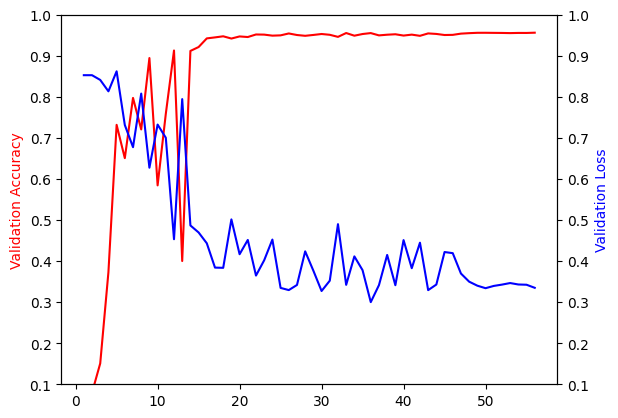

In [ ]:
 #precisão de validação (Validation Accuracy)
 # perda de validação (Validation Loss)

# Épocas e valores val_loss e val_accuracy correspondentes
epochs_list = list(range(1, len(history.history['val_loss']) + 1))
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Trace a época vs val_loss
ax1 = plt.subplot(111)
ax1.plot(epochs_list, val_accuracy, 'r-')
ax1.set_ylabel('Validation Accuracy', color='r')

# Crie um segundo eixo y para val_accuracy
ax2 = ax1.twinx()
ax2.plot(epochs_list, val_loss, 'b-')
ax2.set_ylabel('Validation Loss', color='b')

# Defina a mesma escala nos eixos y
ax1.set_ylim([0.1, 1])
ax2.set_ylim([0.1, 1])

plt.show()

A que o modelo vai fazer as Previsão, das imgens

1/1 [==============================] - 0s 33ms/step


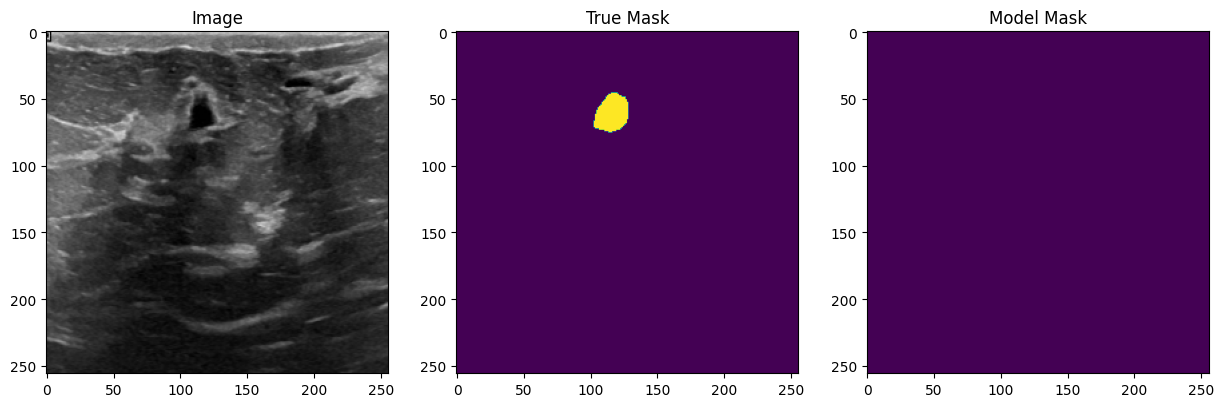

1/1 [==============================] - 0s 21ms/step


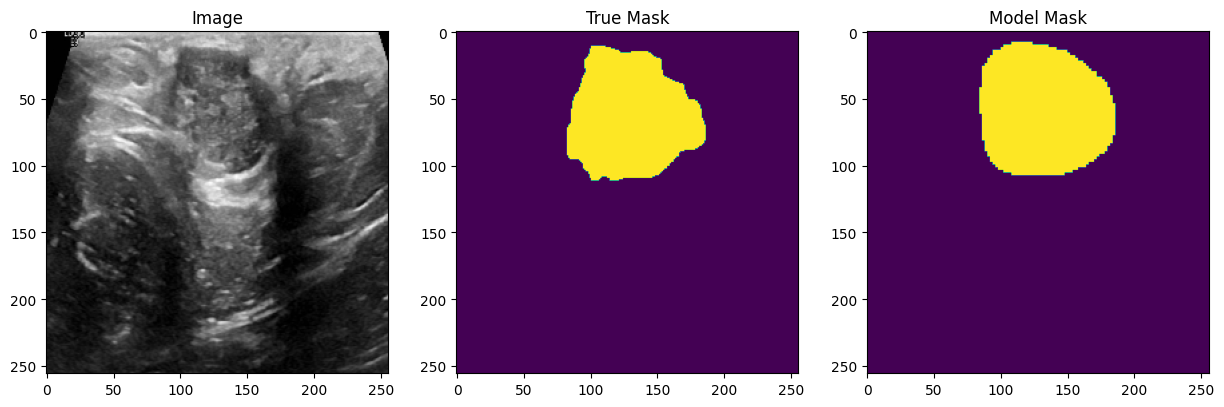

1/1 [==============================] - 0s 19ms/step


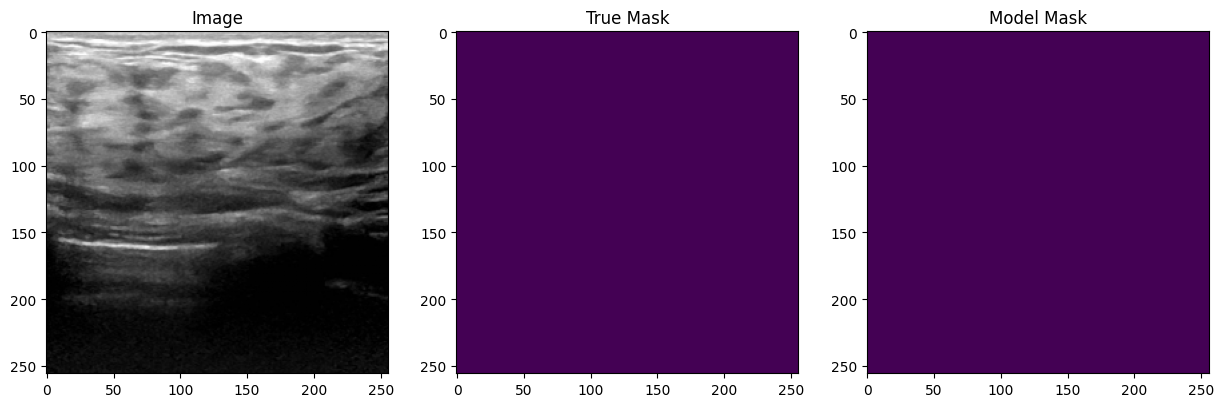

1/1 [==============================] - 0s 20ms/step


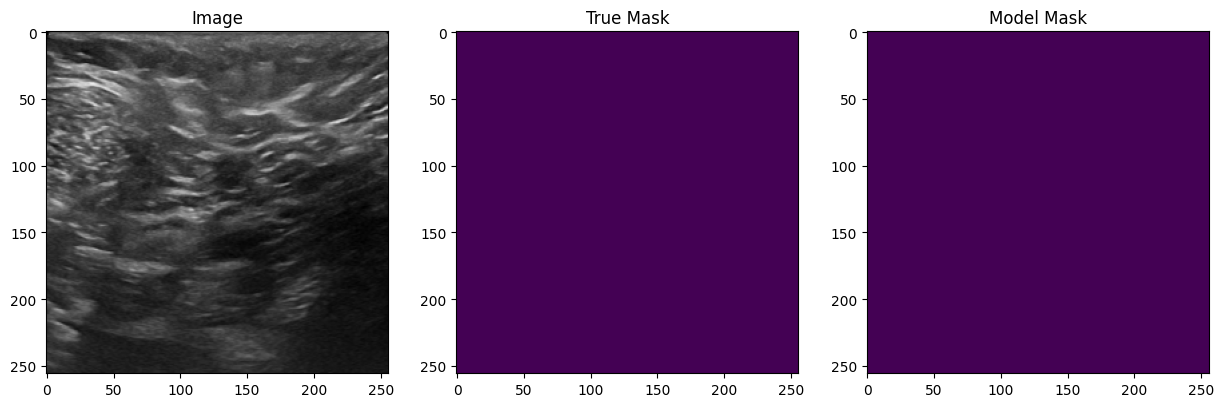

1/1 [==============================] - 0s 21ms/step


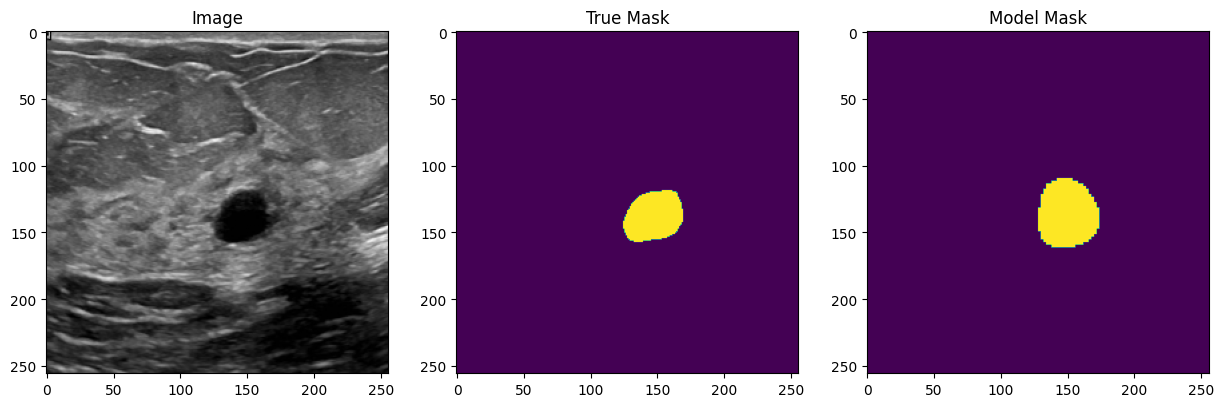

1/1 [==============================] - 0s 21ms/step


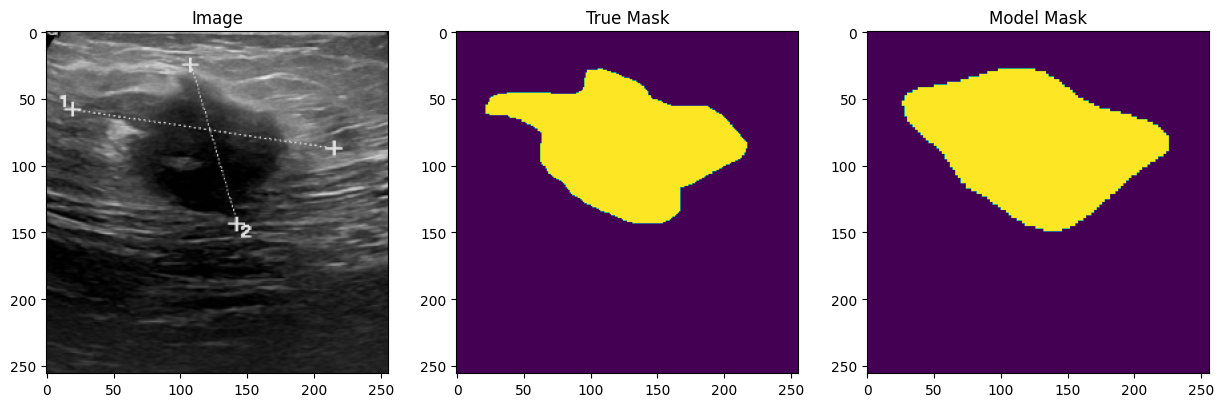

1/1 [==============================] - 0s 21ms/step


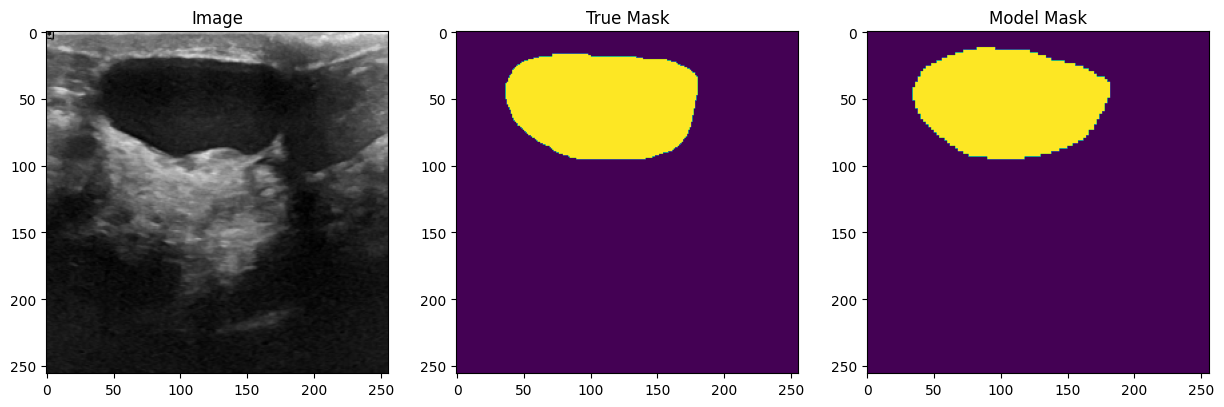

1/1 [==============================] - 0s 19ms/step


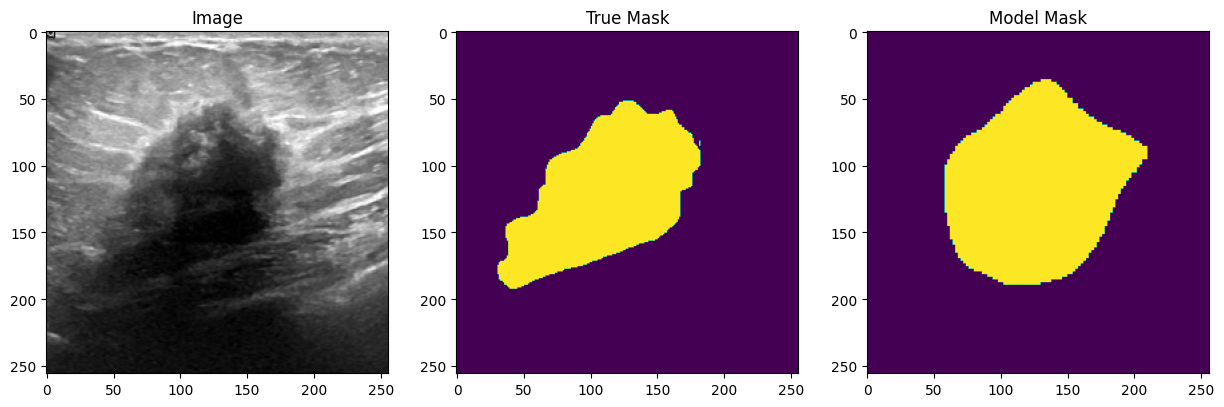

1/1 [==============================] - 0s 19ms/step


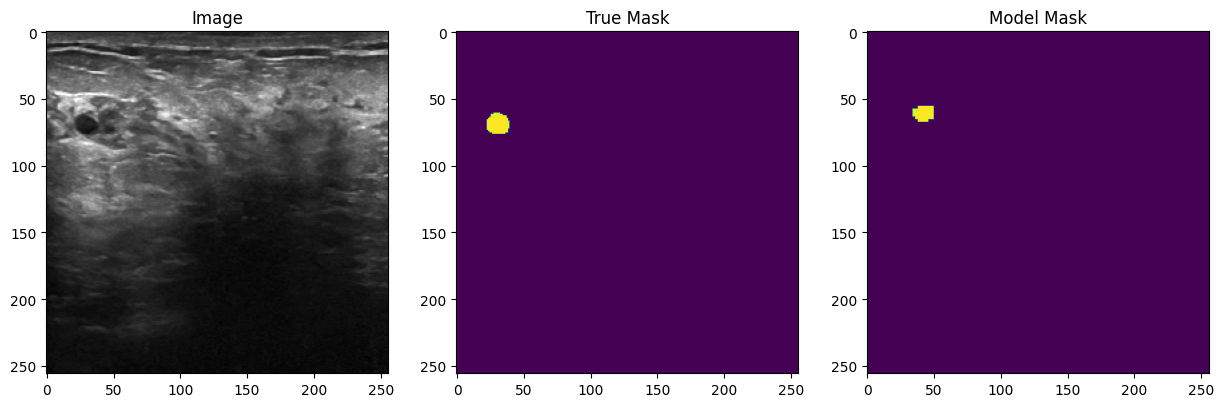

1/1 [==============================] - 0s 20ms/step


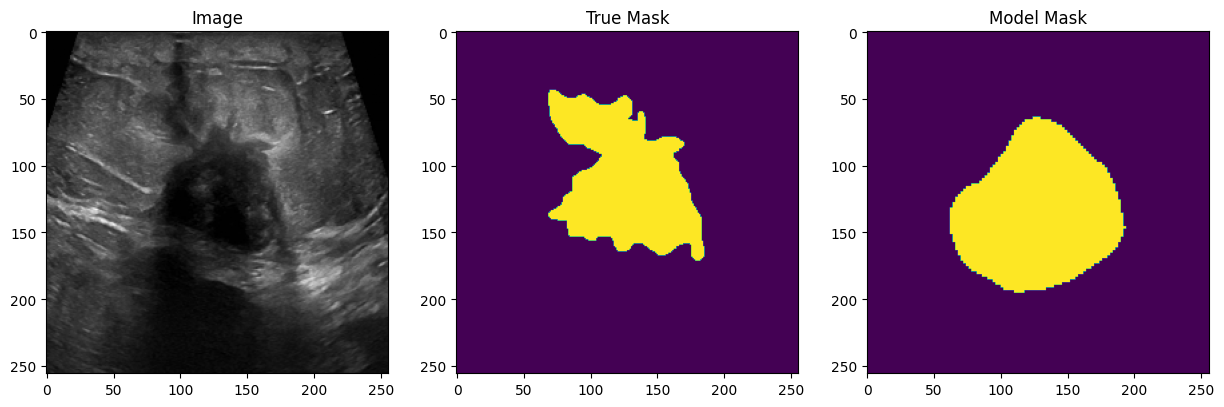

In [ ]:
# Se a probabilidade estimada para uma classe específica for maior que o threshold,
# Função para aplicar a segmentação a uma imagem
def apply_segmentation(image, model, threshold=0.5):
    # Faça uma previsão usando o modelo
    prediction = model.predict(image[None, ...])[0]

    # Aplique um limiar para obter uma máscara binária
    segmentation_mask = (prediction > threshold).astype(np.uint8)

    return segmentation_mask

# Escolha aleatoriamente 5 índices de imagens de teste
random_indices = np.random.choice(len(test_images), size=min(50, len(test_images)), replace=False)

# Visualize as imagens e previsões
for i in random_indices:
    # Selecione uma imagem e sua máscara verdadeira
    image = test_images[i]
    mask = test_masks[i]

    # Aplicar segmentação usando o modelo
    prediction = apply_segmentation(image, model)

    # Exibir a imagem original
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")

    # Exibir a máscara verdadeira
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.title("True Mask")

    # Exibir a máscara prevista pelo modelo
    plt.subplot(1, 3, 3)
    plt.imshow(prediction)
    plt.title("Model Mask")

    plt.show()



Métricas do modelo

In [ ]:
# Faça previsões nas imagens de teste
predictions = model.predict(test_images)

# Calcule a métrica média de IoU no conjunto de teste
mean_iou = tf.keras.metrics.MeanIoU(num_classes=2)
mean_iou.update_state(test_masks, predictions)
print("Média de IoU no conjunto de teste: {:.3f}".format(mean_iou.result()))

# Calcule a precisão e o recall no conjunto de teste
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

precision.update_state(test_masks, predictions)
recall.update_state(test_masks, predictions)

# Calcule a pontuação F1 no conjunto de teste
f1_score = 2 * (precision.result() * recall.result()) / (precision.result() + recall.result())
print("Pontuação F1 no conjunto de testes: {:.3f}".format(f1_score))

# Redefinir as métricas
mean_iou.reset_states()
precision.reset_states()
recall.reset_states()

1/1 [==============================] - 0s 32ms/step
Média de IoU no conjunto de teste: 0.631
Pontuação F1 no conjunto de testes: 0.562


#Gerando Minha matriz de Confusão

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Ajuste as máscaras de teste e as previsões para o formato adequado (flattened)
test_masks_flat = test_masks.flatten()
predictions_flat = predictions.flatten()

# Defina um limiar para converter as probabilidades em classes binárias
threshold = 0.5
predictions_binary = (predictions_flat > threshold).astype(int)


# Calcular a matriz de confusão
conf_matrix = confusion_matrix(test_masks_flat, predictions_binary)

# Adicionar rótulos apropriados para as linhas e colunas
confusion_df = pd.DataFrame(conf_matrix,
                            columns=["Predicted Negative", "Predicted Positive"],
                            index=["Actual Negative", "Actual Positive"])

# Imprimir a matriz de confusão estilizada
print("Matriz de Confusão:")
print(confusion_df)


Matriz de Confusão:
                 Predicted Negative  Predicted Positive
Actual Negative              629113                3938
Actual Positive               12043               10266
